In [1]:
import os, sys
sys.path.append("../..")

import attr
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm

In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
from filterflow.base import State
from filterflow.resampling.standard import SystematicResampler, StratifiedResampler, MultinomialResampler
from filterflow.resampling.base import NoResampling
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver

This notebook aims to demonstrate the differentiability issue encountered at resampling time. To do this we will compare functionals of the point cloud whilst changing a parameter.

In [4]:
tf.random.set_seed(42)

B = 1
N = 50
D = 1

x = tf.random.normal([B, N, D])
y = tf.constant(0.)

weights = tf.random.uniform([B, N], 0., 1.)
weights = weights / tf.reduce_sum(weights, axis=1, keepdims=True)
log_weights = tf.zeros([B, N]) - math.log(N)



In [5]:
@tf.function
def log_likelihood(state, observation, resampler, seed=666):
    tf.random.set_seed(seed)
    rv = tfp.distributions.Normal(0., 1.)
    flags = tf.constant([True])
    log_prob = rv.log_prob(observation-state.particles[:, :, 0])
    log_weights = log_prob - tf.reduce_logsumexp(log_prob, 1, keepdims=True)
    state = attr.evolve(state, log_weights=log_weights, weights=tf.math.exp(log_weights))
    state = resampler.apply(state, flags)
    log_prob = rv.log_prob(observation-state.particles[:, :, 0]) + state.log_weights
    return tf.reduce_logsumexp(log_prob)
    

In [6]:
linspace = np.linspace(-0.5, 0.5, 150).astype(np.float32)

In [7]:
# do not decorate this. seed is being set
def get_data(linspace, resampler, x, y):
    res = []
    grads = []
    for z_val in tqdm.tqdm(linspace):
        z = tf.constant(z_val)
#         tf.random.set_seed(666)
        with tf.GradientTape() as tape:
            tape.watch(z)
            state = State(x + z, log_weights, tf.math.exp(log_weights), tf.constant([0.]))
            ll = log_likelihood(state, y, resampler)
        ll_grad = tape.gradient(ll, z)
        res.append(ll.numpy().sum())
        grads.append(ll_grad.numpy().sum())
    return res, grads
        

In [8]:
systematic = SystematicResampler()
multinomial = MultinomialResampler()
stratified = StratifiedResampler()
no_resampling = NoResampling()

epsilon = tf.constant(0.1)
scaling = tf.constant(0.5)
convergence_threshold = tf.constant(1e-3)
max_iter = tf.constant(500)

regularized = RegularisedTransform(epsilon, scaling, max_iter, convergence_threshold)

step_size = tf.constant(0.25)
horizon = tf.constant(5.)
threshold = tf.constant(1e-2)

solver = PetkovSolver(n_iter=tf.constant(30))
corrected_no_grad = CorrectedRegularizedTransform(epsilon, scaling, max_iter, convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=False)
corrected = CorrectedRegularizedTransform(epsilon, scaling, max_iter, convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=True)

In [9]:
no_resampling_data, no_resampling_grad = get_data(linspace, no_resampling, x, y)
systematic_data, systematic_grad = get_data(linspace, systematic, x, y)
multinomial_data, multinomial_grad = get_data(linspace, multinomial, x, y)
stratified_data, stratified_grad = get_data(linspace, stratified, x, y)

regularized_data, regularized_grad = get_data(linspace, regularized, x, y)
corrected_no_grad_data, corrected_no_grad_grad = get_data(linspace, corrected_no_grad, x, y)
corrected_data, corrected_grad = get_data(linspace, corrected, x, y)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:05<00:00, 28.31it/s]


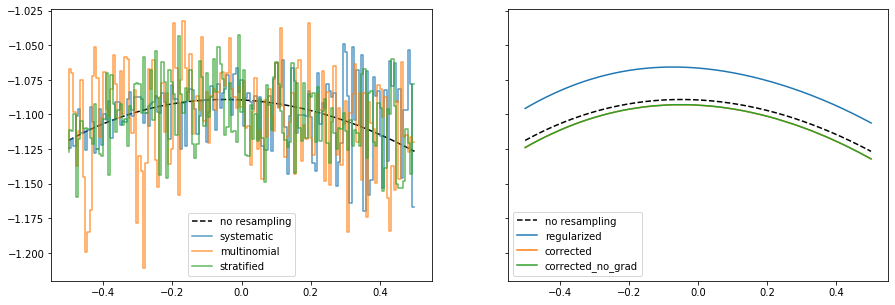

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
axes[0].plot(linspace, no_resampling_data, label='no resampling', linestyle='--', color='k')
axes[1].plot(linspace, no_resampling_data, label='no resampling', linestyle='--', color='k')
axes[0].step(linspace, systematic_data, label='systematic', alpha=0.75)
axes[0].step(linspace, multinomial_data, label='multinomial', alpha=0.75)
axes[0].step(linspace, stratified_data, label='stratified', alpha=0.75)
axes[1].plot(linspace, regularized_data, label='regularized')
axes[1].plot(linspace, corrected_data, label='corrected')
axes[1].plot(linspace, corrected_no_grad_data, label='corrected_no_grad')
_ = axes[0].legend(), axes[1].legend()
fig.savefig(os.path.join('./charts/', 'differentiability_illustration_likelihood.png'))

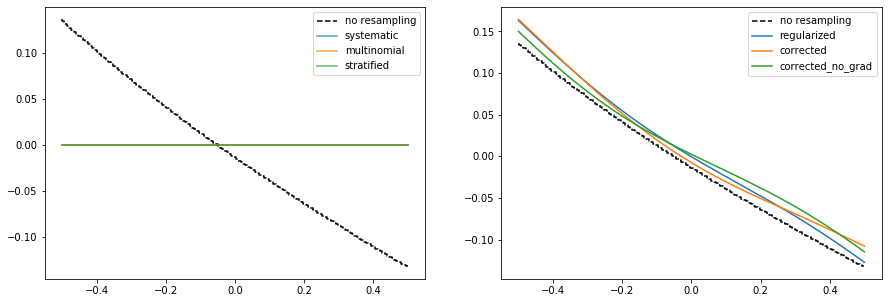

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=False)
axes[0].step(linspace, no_resampling_grad, label='no resampling', linestyle='--', color='k')
axes[1].step(linspace, no_resampling_grad, label='no resampling', linestyle='--', color='k')
axes[0].step(linspace, systematic_grad, label='systematic', alpha=0.75)
axes[0].step(linspace, multinomial_grad, label='multinomial', alpha=0.75)
axes[0].step(linspace, stratified_grad, label='stratified', alpha=0.75)
axes[1].plot(linspace, regularized_grad, label='regularized')
axes[1].plot(linspace, corrected_grad, label='corrected')
axes[1].plot(linspace, corrected_no_grad_grad, label='corrected_no_grad')
_ = axes[0].legend(), axes[1].legend()
fig.savefig(os.path.join('./charts/', 'differentiability_illustration_gradient.png'))